In [185]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
NUM_CLASS = 5
N_BATCH = 32
N_EPOCH = 60
LR = 0.002

In [186]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-03-27 13:00:23.695701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 22455 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-03-27 13:00:23.696127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:1 with 22455 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-03-27 13:00:23.696519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:2 with 22455 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-03-27 13:00:23.696911: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:3 with 22455 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-03-27 13:00:23.697318: I tensorflow/core/common_runtime/gpu/gpu_dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3017052933442462313
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23546626048
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3054137598552543581
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 23546626048
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 661682140120021622
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 23546626048
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8857360503155287186
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6"
 xla_global_id

In [187]:
import numpy as np

datasets = np.load('dataset/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

max_label_length = 4
labels = []
for num in numbers:
    cls = [1] * num if num != 0 else [0]
    cls += [0] * (max_label_length - len(cls))
    labels.append(cls)

# labels = np.array(labels)

non_zero_indices = np.where(numbers != 0)[0]

# numbers가 0이 아닌 항목만 유지
images_filtered = images[non_zero_indices]
bboxes_filtered = bboxes[non_zero_indices]
labels_filtered = np.array(labels)[non_zero_indices]

print(images.shape, numbers.shape, bboxes.shape, len(labels))

print(images.max(), images.min())
# print(bboxes[0:9100])
# print(labels[0:9100])
# labels = np.array(labels)

dataset = {
    'images' : images_filtered,
    'bboxes' : bboxes_filtered,
    'class' : labels_filtered
}

print(dataset['images'].shape)
print(dataset['bboxes'].shape)
print(len(dataset['class']))


(17820, 24, 32, 1) (17820,) (17820, 4, 4) 17820
255 0
(16824, 24, 32, 1)
(16824, 4, 4)
16824


In [188]:
print(dataset['class'][16000])

[1 1 1 0]


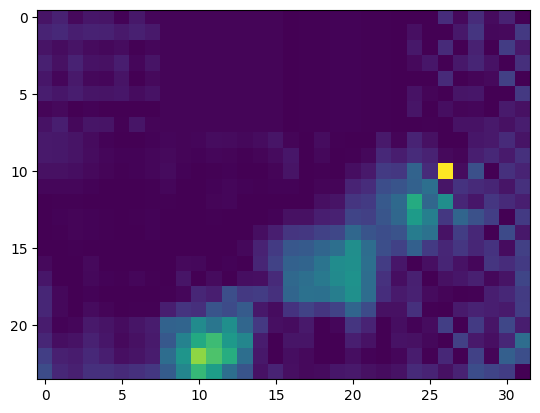

In [189]:
plt.imshow(dataset['images'][16000])

In [190]:
print(dataset['bboxes'][9000])

[[ 4 13 12 22]
 [10  4 18 15]
 [25  8 32 14]
 [ 0  0  0  0]]


(24, 32, 1)
24
32
[[ 7 17 15 24]
 [13 13 23 21]
 [19  8 28 17]
 [ 0  0  0  0]]
bbox:  tf.Tensor(
[[ 7 17 15 24]
 [13 13 23 21]
 [19  8 28 17]
 [ 0  0  0  0]], shape=(4, 4), dtype=int64)


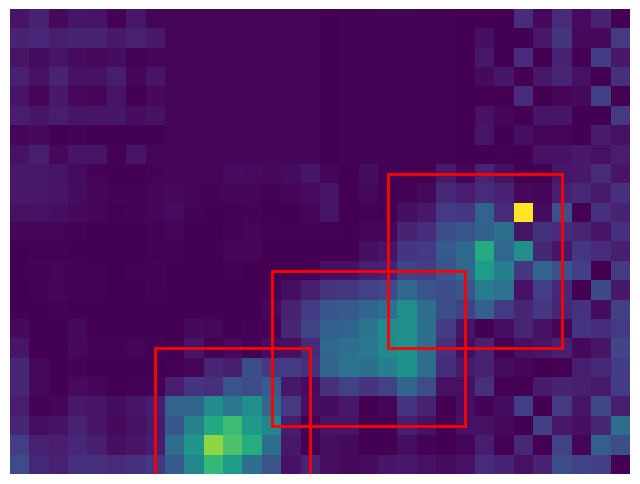

[1 1 1 0]


In [191]:
import matplotlib.pyplot as plt
import tensorflow as tf
images = dataset['images']
bboxes = dataset['bboxes']
cls = dataset['class']

boxes = bboxes[16000]
plt.figure(figsize = (8, 8))
plt.axis('off')
image = images[16000]
print(image.shape)
print(image.shape[0])
print(image.shape[1])
print(boxes)
plt.imshow(image)
ax = plt.gca()
boxes = tf.stack([
	(boxes[:, 0] ), 
	(boxes[:, 1] ),
	(boxes[:, 2] ),
	(boxes[:, 3] )], axis = -1
)
print("bbox: ", boxes)
# 각 바운딩 박스에 대해 반복하여 그리기
for box in boxes:
    xmin, ymin, xmax, ymax = box 
    w, h = xmax - xmin, ymax - ymin
    patch = plt.Rectangle(
        [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
    )
    ax.add_patch(patch)
plt.show()
print(cls[16000])

In [192]:
images.max(), images.min()

(255, 0)

In [193]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_TRAIN = images.shape[0]
LOG_DIR = 'Log/v1'

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'dataset/tfrecord/')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)



shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'dataset/tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)

IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           16824
N_TRAIN:          16824


In [194]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int32_list = tf.train.Int64List(value = [value]))


def _bytes_feature_list(value_list):
    """value_list가 리스트일 때, 이를 serialize하여 bytes list로 변환하는 함수."""
    value_list = [tf.io.serialize_tensor(tf.constant(v)).numpy() for v in value_list]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value_list))


In [195]:
max_label_length = max(len(cls) for cls in labels)
print(max_label_length)

4


In [196]:
images = dataset['images']
bboxes = dataset['bboxes']
cls = dataset['class']
print(images.shape)

(16824, 24, 32, 1)


In [197]:
for idx in train_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    class_id = cls[idx]
    # print(len(cls))
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    
    writer_train.write(example.SerializeToString())
writer_train.close()


In [198]:
AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT =24
RES_WIDTH = 32
N_EPOCHS = 100
N_BATCH = 9
# LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
        # 'number': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = image / tf.reduce_max(image)
    image = tf.cast(image, tf.float32) 
    # image = image / tf.reduce_max(image)

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    # num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int64)
    
    # number = tf.cast(parsed_features['number'], tf.int64)
    return image, bbox, label


train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [199]:
def convert_types(image, bbox, label):
    # 필요한 필드의 데이터 타입을 int32로 변환
    label = tf.cast(label, tf.int32)
    # 추가적인 필드가 있다면 여기에 tf.cast 적용
    return image, bbox, label

train_dataset = train_dataset.map(convert_types)


(24, 32, 1)
tf.Tensor([1 1 1 0], shape=(4,), dtype=int32)
tf.Tensor(
[[22. 14. 28. 24.]
 [26. 15. 32. 23.]
 [24.  8. 32. 16.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


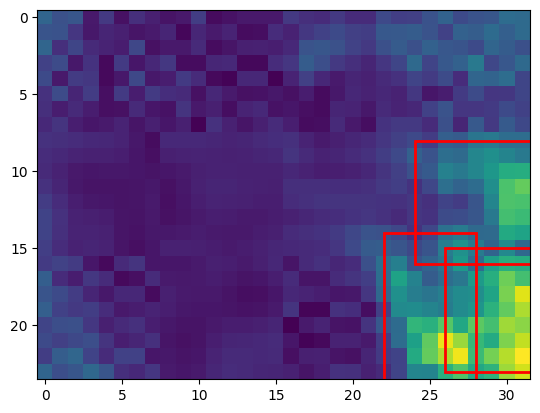

In [200]:
import matplotlib.pyplot as plt

idx = 0
for image, bbox, label in train_dataset.take(1):
    image = image[idx]
    bbox = bbox[idx]
    label = label[idx]
    image = image.numpy()
    plt.imshow(image)
    ax = plt.gca()  
    print(image.shape)
    print(label)
    print(bbox)
    boxes = tf.stack(
    	[
    	 bbox[:,0],
    	 bbox[:,1],
    	 bbox[:,2],
    	 bbox[:,3]
    	], axis = -1
    )
    for box in boxes:
        xmin, ymin = box[:2]
        w, h = box[2:] - box[:2]
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()

In [201]:
def convert_to_xywh(boxes):    
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

In [202]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )

In [203]:
def preprocess_data(image, gt_boxes, cls_ids):
    cls_ids = tf.cast(cls_ids, dtype = tf.int32)
    
    bbox = convert_to_xywh(gt_boxes)
    print(image.shape)
    print(bbox.shape)
    print(cls_ids.shape)
    return image, bbox, cls_ids

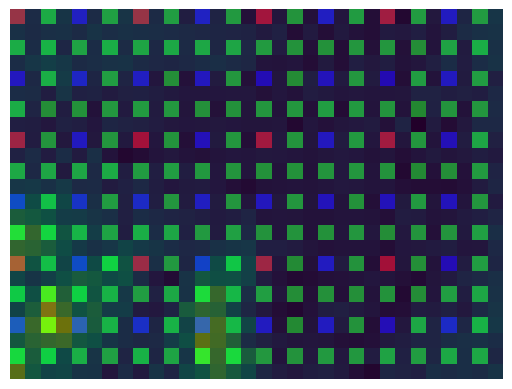

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [204]:
idx = 0
for image, bbox, label in train_dataset.take(1):
    anchor_img = np.zeros((*image.shape[:3], 3), dtype=np.uint8)
    anchor_img = anchor_img[idx]

    strides = [2, 4, 8]
    colors = {
        2: [0, 255, 0],  # 초록색
        4: [0, 0, 255],  # 파란색
        8: [255, 0, 0],   # 빨간색
    }

    for stride in strides:
        color = colors[stride]
        for y in range(0, anchor_img.shape[0], stride):
            for x in range(0, anchor_img.shape[1], stride):
                anchor_img[y, x, :] = color

    # 이미지 표시
    plt.imshow(image[idx], alpha=1)  
    plt.imshow(anchor_img, alpha=0.5) 
    plt.axis('off')
    plt.show()
    print(tf.reduce_max(image), tf.reduce_min(image))

(9, 24, 32, 1)
(9, 4, 4)
(9, 4)
(24, 32, 1)
tf.Tensor(
[[13.5 21.5  7.   5. ]
 [27.  13.5 10.   9. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]], shape=(4, 4), dtype=float32)
tf.Tensor([1 1 0 0], shape=(4,), dtype=int32)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
width:  32
height:  24
bbox:  tf.Tensor(
[[10. 19.  7.  5.]
 [22.  9. 10.  9.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)
tf.Tensor([10. 19.  7.  5.], shape=(4,), dtype=float32)
tf.Tensor([22.  9. 10.  9.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


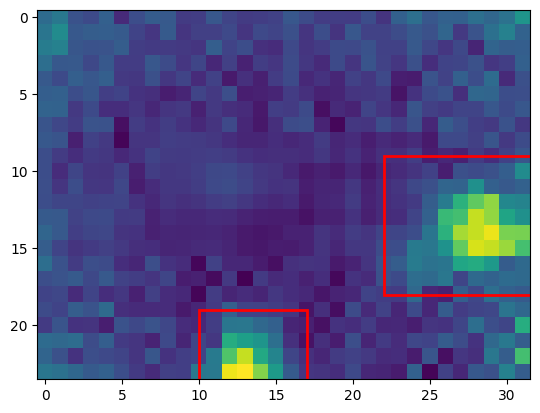

tf.Tensor([1 1 0 0], shape=(4,), dtype=int32)


In [205]:
idx = 0
for image, bbox, label in train_dataset.take(1):
    image, bbox, label = preprocess_data(image, bbox, label)
    img = image[idx]
    box = bbox[idx]
    label = label[idx]
    print(img.shape)
    print(box)
    print(label)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    width = img.shape[1]
    height = img.shape[0]
    print("width: ", width)
    print("height: ", height)
    boxes = tf.stack(
        [
            (box[:, 0] - 0.5 * box[:, 2]),  # xmin = x_center - width/2
            (box[:, 1] - 0.5 * box[:, 3]),  # ymin = y_center - height/2
            box[:, 2],
            box[:, 3],
            
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes:
        xmin, ymin, w, h = box
        print(box)
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()
    print(label)
 

self.aspect_ratios = [0.5, 1.0, 2.0]        
self.scales = [2** x for x in [0, 1/3, 2/3]] 

self.aspect_ratios * self.scales = 9 이므로 

(None, 12, 16, 32) // stride 2

(None, 6, 8, 32)   // stride 4

(None, 3, 4, 32)   // stride 8

가 출력이다 그래서 총 갯수가 2268개이다 

그럼 AnchorBox도 

self._strides = [2 ** i for i in range(1, 4)] 

stride = 2, 4, 8 이 나와야 하며 그에 따라 self._areas = [x ** 2 for x in [5.5, 6.0, 6.5]] 
self._areas 도 3개가 나와야 한다 

그러면 

12 * 16 * 9 = 1,728

6 * 8 * 9 = 432

3 * 4 * 9 = 108

== > 1,728 + 432 + 108 = 2,268 인 바운딩 박스 갯수와 출력 갯수가 일치하게 된다 !



In [249]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]         # 이거랑 2268
        self.scales = [2** x for x in [0, 1/3, 2/3]] # 이걸로 바운딩박스 갯수 조절가능
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(1, 4)]
        self._areas = [x ** 2 for x in [5.5, 6.0, 6.5]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []

        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios: 
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis = -1), [1, 1, 2]
                )
                for scale in self.scales: 
                    anchor_dims.append(scale * dims) 
            anchor_dims_all.append(tf.stack(anchor_dims, axis = -2))
        return anchor_dims_all 
    
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype = tf.float32) + 0.5
        ry = tf.range(feature_height, dtype = tf.float32) + 0.5

        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level - 1]
        centers = tf.expand_dims(centers, axis = -2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])

        dims = tf.tile(
            self._anchor_dims[level - 1], [feature_height, feature_width, 1, 1] 
        )

        anchors = tf.concat([centers, dims], axis=-1) 
        # print(f"anchors: {anchors}")

        # print(f"{tf.reshape(anchors, [feature_height * feature_width * self._num_anchors, 4]).shape}")

        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), # 올림
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(1, 4)
        ]

        return tf.concat(anchors, axis=0)

        # 앵커 박스의 좌표를 이미지 크기 내로 제한
        # anchors = tf.clip_by_value(anchors, 0, [image_height, image_width, image_height, image_width])
        # return tf.concat(anchors, axis=0)
        # return anchors

Anchor 음수 값: False
tf.Tensor(
[[ 1.         1.         3.8890874  7.7781744]
 [ 1.         1.         4.8999434  9.799886 ]
 [ 1.         1.         6.1735415 12.347082 ]
 ...
 [28.        20.         9.192389   4.596194 ]
 [28.        20.        11.581684   5.7908416]
 [28.        20.        14.592007   7.296003 ]], shape=(2268, 4), dtype=float32)
(2268, 4)
(24, 32, 1)
[[11.        23.         4.8999434  9.799886 ]
 [23.         7.         6.929566   6.929566 ]
 [17.         9.         7.778175   3.8890872]
 ...
 [14.         2.        10.690785   5.345392 ]
 [ 9.        17.        12.347083   6.173541 ]
 [13.        13.         6.929566   6.929566 ]]


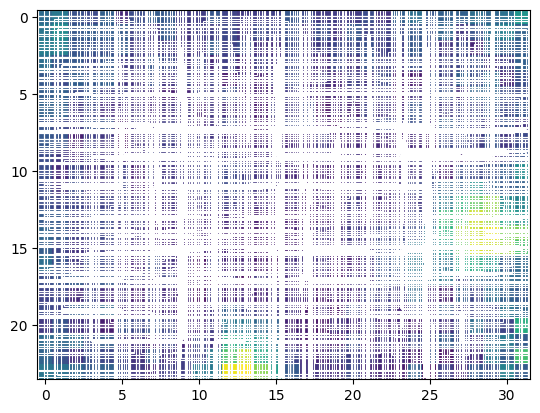

In [207]:
anchors = AnchorBox()
anchor = anchors.get_anchors(24, 32)

has_negative_values = tf.reduce_any(tf.less(anchor, 0))
print("Anchor 음수 값:", has_negative_values.numpy())

print(anchor)
print(anchor.shape)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(data, num_samples):
    fig, ax = plt.subplots()

    plt.imshow(img)
    print(img.shape)
    data_np = data.numpy()

    if len(data) > num_samples:
        sampled_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_data = data_np[sampled_indices]
    else : 
        sample_data = data_np
    print(sample_data)
    for center_x, center_y, width, height in sample_data:
        top_left_x = center_x - width / 2
        top_left_y = center_y - height / 2

        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=0.8, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

draw_bounding_boxes(anchor, 1000)


In [208]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    # print("boxes1: ", boxes1.shape)
    # print("boxes1_corners: ", boxes1_corners.shape)
    boxes2_corners = convert_to_corners(boxes2)
    # print("boxes2: ", boxes2.shape)
    # print("boxes2_corners: ", boxes2_corners.shape)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    # print("lu: ", lu.shape)
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])  
    # print("rd: ", rd.shape)

    
    intersection = tf.maximum(rd - lu, 0.0)
    # print("intersection: ", intersection.shape)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    # print("intersection_area: ", intersection_area.shape)
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    # print("union_area: ", union_area.shape)
    # return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)
    # print(intersection_area / union_area)
    return intersection_area / union_area

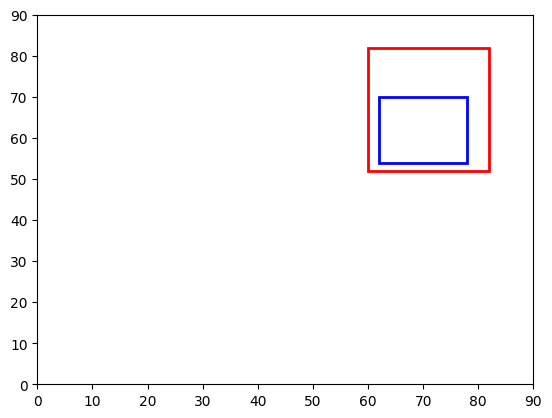

In [209]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 주어진 바운딩 박스 데이터
box1 = [62, 54, 78, 70]  # [x_min, y_min, x_max, y_max]
box2 = [60, 52, 82, 82]

# 그림 생성
fig, ax = plt.subplots()

# 첫 번째 바운딩 박스 추가
rect1 = patches.Rectangle((box1[0], box1[1]), box1[2] - box1[0], box1[3] - box1[1], 
                          linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(rect1)

# 두 번째 바운딩 박스 추가
rect2 = patches.Rectangle((box2[0], box2[1]), box2[2] - box2[0], box2[3] - box2[1], 
                          linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect2)

# 축 범위 설정
ax.set_xlim(0, 90)
ax.set_ylim(0, 90)

# 그림 표시
plt.show()



In [210]:
GA = np.array([[70, 62, 16, 16]])
GT = np.array([[76, 72, 32, 40]])

print(compute_iou(GA, GT))

tf.Tensor([[0.2]], shape=(1, 1), dtype=float64)


In [211]:
gt_boxes = np.array([[27.,  18.5,  8.,   7., ],
                     [18.5, 15.5, 11.,   7. ]])

print(gt_boxes.shape)
matched_gt_idx = tf.reduce_sum(gt_boxes, axis = 0)
print(matched_gt_idx)

matched_gt_idx = tf.reduce_sum(gt_boxes, axis = 1)
print(matched_gt_idx)

(2, 4)
tf.Tensor([45.5 34.  19.  14. ], shape=(4,), dtype=float64)
tf.Tensor([60.5 52. ], shape=(2,), dtype=float64)


In [212]:
def match_anchor_boxes(anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        print("iou_matrix:  ", iou_matrix)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        print("max_iou:  ", max_iou)


        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)
        print("matched_gt_idx:  ", matched_gt_idx)
    
        positive_mask = tf.greater_equal(max_iou, match_iou)
        print("positive_mask:  ", positive_mask)
        negative_mask = tf.less(max_iou, ignore_iou)
        print("negative_mask:  ", negative_mask)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        print("ignore_mask:  ", ignore_mask)
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
        

In [213]:
# anchors = AnchorBox()
# anchor = anchors.get_anchors(24, 32)
# print(anchor.shape)
# anchor_boxes = np.array([[27.0, 23.0, 8.485282, 4.2426405]])
anchor = np.array([[27.,  18.5,  8.,   7., ],
                     [18.5, 15.5, 11.,   7. ],
                     [ 6.,   4.,   8.,   6. ],
                     [ 0.,   0.,   0.,   0. ],
                     [ 1., 1., 4.242641, 8.485281 ],
                     [ 1.,         1.,         5.3453927, 10.690784 ],
                    [ 1.,         1.,         6.7347727, 13.469543 ],
                    [30.,        22.,         9.899496,   4.949747 ]])

gt_boxes = np.array([[27.,  18.5,  8.,   7., ],
                     [18.5, 15.5, 11.,   7. ],
                     [ 6.,   4.,   8.,   6. ],
                     [ 0.,   0.,   0.,   0. ]])
# print(gt_boxes.shape)
a, b, c = match_anchor_boxes(tf.cast(anchor, tf.float32), tf.cast(gt_boxes, tf.float32))
# print(a, b, c)

iou_matrix:   tf.Tensor(
[[1.         0.03100775 0.         0.        ]
 [0.03100775 1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.06003535 0.        ]
 [0.         0.         0.09293901 0.        ]
 [0.         0.         0.11408175 0.        ]
 [0.16311105 0.         0.         0.        ]], shape=(8, 4), dtype=float32)
max_iou:   tf.Tensor(
[1.         1.         1.         0.         0.06003535 0.09293901
 0.11408175 0.16311105], shape=(8,), dtype=float32)
matched_gt_idx:   tf.Tensor([0 1 2 0 2 2 2 0], shape=(8,), dtype=int64)
positive_mask:   tf.Tensor([ True  True  True False False False False False], shape=(8,), dtype=bool)
negative_mask:   tf.Tensor([False False False  True  True  True  True  True], shape=(8,), dtype=bool)
ignore_mask:   tf.Tensor([False False False False False False False False], shape=(8,), dtype=bool)


In [214]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    
    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        print("iou_matrix:  ", iou_matrix.shape)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        print("max_iou:  ", max_iou.shape)

        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)
        print("matched_gt_idx:  ", matched_gt_idx)
        print("max_iou:", max_iou)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        print("positive_mask:  ", positive_mask)
        negative_mask = tf.less(max_iou, ignore_iou)
        print("negative_mask:  ", negative_mask.shape)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        print("ignore_mask:  ", ignore_mask.shape)
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis = -1,
        )
        print("box_target:  ", box_target)
        box_target = box_target / self._box_variance
        print("box_target:  ", box_target)
        return box_target
    

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        print("anchor_boxes  : ", anchor_boxes)
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        print("cls_ids", cls_ids)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        print("matched_gt_idx:  ", matched_gt_idx)
        print("positive_mask:  ", positive_mask)
        print("ignore_mask:  ", ignore_mask)

        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)

        print("matched_gt_boxes:  ", matched_gt_boxes)
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        print("box_target:  ", box_target)

        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        print("matched_gt_cls_ids:  ", matched_gt_cls_ids)
        
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        print("cls_target:  ", cls_target)

        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        print("cls_target:  ", cls_target)

        cls_target = tf.expand_dims(cls_target, axis=-1)
        print("cls_target:  ", cls_target)


        label = tf.concat([box_target, cls_target], axis=-1)
        print("label:  ", label)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):       
        images_shape = tf.shape(batch_images)
        print("images_shape:  ", images_shape)
        batch_size = images_shape[0]
        print("batch_size:  ", batch_size)

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        print("labels:  ", labels)
        # batch_size_val = batch_size.numpy()
        for i in range(1):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            print("label:  ", label)
            labels = labels.write(i, label)
        return batch_images, labels.stack()

In [215]:
print("Eager execution: ", tf.executing_eagerly())
if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

Eager execution:  True


In [216]:
label_encoder = LabelEncoder()

for image, bbox, label in train_dataset.take(1):
    img, box, label = preprocess_data(image, bbox, label)
    # img = np.expand_dims(img, axis = 0)
    # box = np.expand_dims(box, axis = 0)
    # label = np.expand_dims(label, axis = 0)
    print(img.shape, box.shape, label.shape)

    label_encoder.encode_batch(img, box, label)
    

(9, 24, 32, 1)
(9, 4, 4)
(9, 4)
(9, 24, 32, 1) (9, 4, 4) (9, 4)
images_shape:   tf.Tensor([ 9 24 32  1], shape=(4,), dtype=int32)
batch_size:   tf.Tensor(9, shape=(), dtype=int32)
labels:   <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7fd8c879ba00>
anchor_boxes  :  tf.Tensor(
[[ 1.         1.         3.8890874  7.7781744]
 [ 1.         1.         4.8999434  9.799886 ]
 [ 1.         1.         6.1735415 12.347082 ]
 ...
 [28.        20.         9.192389   4.596194 ]
 [28.        20.        11.581684   5.7908416]
 [28.        20.        14.592007   7.296003 ]], shape=(2268, 4), dtype=float32)
cls_ids tf.Tensor([1. 1. 0. 0.], shape=(4,), dtype=float32)
iou_matrix:   (2268, 4)
max_iou:   (2268,)
matched_gt_idx:   tf.Tensor([0 0 0 ... 0 0 0], shape=(2268,), dtype=int64)
max_iou: tf.Tensor([0.0412993  0.06759299 0.10082412 ... 0.         0.         0.        ], shape=(2268,), dtype=float32)
positive_mask:   tf.Tensor([False False False ... False False False], shape=(2268,)

In [217]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
num_classes = 1
batch_size = 9

train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
# train_dataset = train_dataset.shuffle(batch_size * 8)

# train_dataset = train_dataset.padded_batch(
#     batch_size=batch_size, 
#     padded_shapes = ([9, 24, 32, 1], [9, 4, 4], [9, 4]),
#     padding_values=(0.0, 1e-8, -1), 
#     drop_remainder=True
# )

(9, 24, 32, 1)
(9, None, 4)
<unknown>


In [218]:
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
# train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

images_shape:   Tensor("Shape:0", shape=(4,), dtype=int32)
batch_size:   Tensor("strided_slice:0", shape=(), dtype=int32)
labels:   <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7fd8b8715490>
anchor_boxes  :  Tensor("concat_3:0", shape=(2268, 4), dtype=float32)
cls_ids Tensor("Cast:0", dtype=float32)
iou_matrix:   (2268, None)
max_iou:   (2268,)
matched_gt_idx:   Tensor("ArgMax:0", shape=(2268,), dtype=int64)
max_iou: Tensor("Max:0", shape=(2268,), dtype=float32)
positive_mask:   Tensor("GreaterEqual:0", shape=(2268,), dtype=bool)
negative_mask:   (2268,)
ignore_mask:   (2268,)
matched_gt_idx:   Tensor("ArgMax:0", shape=(2268,), dtype=int64)
positive_mask:   Tensor("Cast_1:0", shape=(2268,), dtype=float32)
ignore_mask:   Tensor("Cast_2:0", shape=(2268,), dtype=float32)
matched_gt_boxes:   Tensor("GatherV2:0", shape=(2268, 4), dtype=float32)
box_target:   Tensor("concat_6:0", shape=(2268, 4), dtype=float32)
box_target:   Tensor("truediv_13:0", shape=(2268, 4), dtype=fl

In [248]:
positive_count = []
negative_count = []
ignore_count = []
for batch in train_dataset.take(10):
    images, labels = batch
    print(labels.shape)

    # labels 텐서에서 positive, negative, ignore 값의 개수를 계산
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[0, :, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())


(9, 2268, 5)
Positive 개수: 24
Negative 개수: 2223
Ignore 개수: 21
(9, 2268, 5)
Positive 개수: 18
Negative 개수: 2210
Ignore 개수: 40
(9, 2268, 5)
Positive 개수: 39
Negative 개수: 2155
Ignore 개수: 74
(9, 2268, 5)
Positive 개수: 30
Negative 개수: 2163
Ignore 개수: 75
(9, 2268, 5)
Positive 개수: 40
Negative 개수: 2138
Ignore 개수: 90
(9, 2268, 5)
Positive 개수: 45
Negative 개수: 2148
Ignore 개수: 75
(9, 2268, 5)
Positive 개수: 76
Negative 개수: 2108
Ignore 개수: 84
(9, 2268, 5)
Positive 개수: 21
Negative 개수: 2220
Ignore 개수: 27
(9, 2268, 5)
Positive 개수: 65
Negative 개수: 2112
Ignore 개수: 91
(9, 2268, 5)
Positive 개수: 22
Negative 개수: 2202
Ignore 개수: 44


In [220]:
# def cut_labels(images, labels):
#     # ignore 상태가 아닌 앵커 박스만 필터링
#     mask = tf.not_equal(labels[:, 4], -2.0)
#     filtered_labels = tf.boolean_mask(labels, mask)

#     # 필터링된 레이블을 원하는 크기로 조절
#     desired_count = 24192
#     current_count = tf.shape(filtered_labels)[0]

#     # 필요한 경우 레이블을 패딩
#     if current_count < desired_count:
#         # 누락된 개수만큼 ignore 상태(-2.0)로 패딩
#         padding_count = desired_count - current_count
#         padding = tf.fill([padding_count, 5], -2.0)  # -2.0으로 채워진 텐서 생성
#         filtered_labels = tf.concat([filtered_labels, padding], axis=0)
#     else:
#         filtered_labels = filtered_labels[:desired_count, :]

#     return images, filtered_labels

2
(9, 24, 32, 1)
(9, 2268, 5)


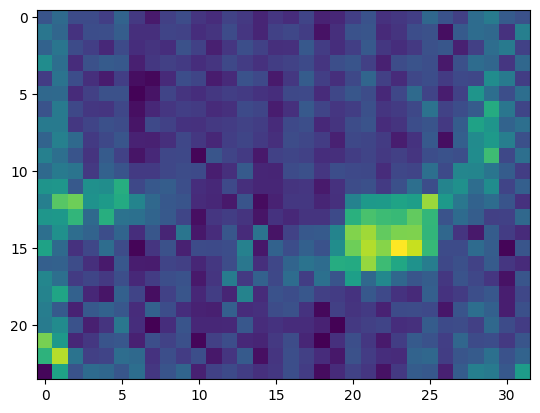

tf.Tensor(8, shape=(), dtype=int32)


In [221]:
for batch in train_dataset.take(1):
    print(len(batch))
    print(batch[0].shape) # 이미지
    print(batch[1].shape) # 라벨
    plt.imshow(batch[0][0])
    plt.show()
    print(tf.reduce_sum(tf.cast(tf.equal(batch[1][0, :, 4], 1.0), tf.int32)))


Positive 개수: 76
Negative 개수: 2064
Ignore 개수: 128
Positive 76


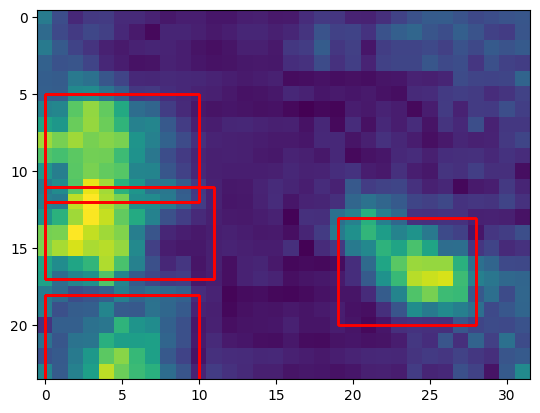

In [222]:
def decode_predictions(labels, anchors, box_variance=[0.1, 0.1, 0.2, 0.2]):
    decoded_boxes = []
    label_idx = 0
    for label in labels:
        # if label[4] == 1.0:
        #     print("label:", label)
        # elif label[4] == -1.0:
        #     print("label:", label)
        dx, dy, dw, dh = label[:4]
        anchor = anchors[label_idx]
        anchor_x, anchor_y, anchor_w, anchor_h = anchor
        cx = dx * box_variance[0] * anchor_w + anchor_x
        cy = dy * box_variance[1] * anchor_h + anchor_y
        width = np.exp(dw * box_variance[2]) * anchor_w
        height = np.exp(dh * box_variance[3]) * anchor_h
        x_min = cx - width / 2
        y_min = cy - height / 2
        decoded_box = [x_min, y_min, width, height]
        # print(np.array(decoded_box))
        if label[4] == 1.0:
            decoded_boxes.append(decoded_box)
        label_idx += 1
        # if len(np.array(decoded_boxes)) > 1: 
            # break
    print("Positive",len(np.array(decoded_boxes)))
    return decoded_boxes    
    # print(np.array(decoded_boxes))
    


# 바운딩 박스 그리기 함수
def draw_positive_bounding_boxes(image, decoded_boxes):
    plt.imshow(image)
    ax = plt.gca()
    # print(len(decoded_boxes))
    i = 0
    for box in decoded_boxes:
        i+=1
        # print(box)
        x_min, y_min, width, height = box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # print(i)
    plt.show()

# 앵커 박스 생성
anchor_box = AnchorBox()
anchors = anchor_box.get_anchors(24, 32)
# train_dataset에서 첫 번째 배치를 가져오고, 바운딩 박스 그리기
for batch in train_dataset.take(1):
    image = batch[0][0].numpy()
    labels = batch[1][0].numpy()  # 여기서 labels는 [오프셋x, 오프셋y, 스케일w, 스케일h, 클래스, 앵커 박스 인덱스]를 포함한다고 가정
    # print(labels)
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())

    # 오프셋 디코딩 및 바운딩 박스 그리기
    decoded_boxes = decode_predictions(labels, anchors)
    draw_positive_bounding_boxes(image, decoded_boxes)

In [223]:
print(np.array(decoded_boxes).shape)

(76, 4)


In [224]:
class DepthwiseSeparableConv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = layers.DepthwiseConv2D(kernel_size=kernel_size, padding='same' if padding else 'valid', depth_multiplier=1, strides=stride)
        self.pointwise = layers.Conv2D(out_channels, kernel_size=1, strides=1)

    def call(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class DepthwiseConv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseConv, self).__init__()
        self.depthwise = DepthwiseSeparableConv(in_channels, out_channels, kernel_size, stride, padding)
        self.batch_norm = layers.BatchNormalization()
        self.silu = layers.Activation('silu')

    def call(self, x):
        out = self.depthwise(x)
        out = self.batch_norm(out)
        out = self.silu(out)
        return out

In [225]:
class Conv(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(out_channels, kernel_size, strides=stride, padding='same')
        self.batch_norm = layers.BatchNormalization()
        self.silu = layers.Activation('silu')

    def call(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        return self.silu(x)

In [226]:
class Bottleneck(layers.Layer):
    def __init__(self, in_out_channels, mid_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv_0 = Conv(in_out_channels, mid_channels, kernel_size=1, stride=stride, padding=0)
        self.conv_1 = Conv(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1)
        self.conv_3 = Conv(mid_channels, in_out_channels, kernel_size=1, stride=stride, padding=0)

    def call(self, x):
        identity = x
        out = self.conv_0(x)
        out = self.conv_1(out)
        out = self.conv_3(out)
        out += identity
        return out

In [227]:
class CSPDenseLayer(layers.Layer):
    def __init__(self, in_out_channels, bottleneck_mid_channels, out_channels):
        super(CSPDenseLayer, self).__init__()
        self.conv_0 = DepthwiseConv(in_out_channels // 2, in_out_channels, stride=1)
        self.conv_1 = DepthwiseConv(in_out_channels // 2, in_out_channels, stride=1)
        self.bottleneck = Bottleneck(in_out_channels, bottleneck_mid_channels)
        self.conv_3 = Conv(in_out_channels * 2, out_channels, stride=1)

    def call(self, x):
        x1, x2 = tf.split(x, num_or_size_splits=2, axis=-1)
        x1 = self.conv_0(x1)
        x2 = self.conv_1(x2)
        out = self.bottleneck(x1)
        out = tf.concat([out, x2], axis=-1)
        out = self.conv_3(out)
        return out

In [228]:
class ChannelAttention(layers.Layer):
    def __init__(self, in_channels, reduction_ratio=16, pool_types=['avg', 'max'], kernel_size=7):
        super(ChannelAttention, self).__init__()
        self.pool_types = pool_types
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        pooled_features = []
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                pooled = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
            elif pool_type == 'max':
                pooled = tf.reduce_max(x, axis=[1, 2], keepdims=True)
            pooled_features.append(pooled)
        
        concat = tf.concat(pooled_features, axis=-1)
        attention = self.conv(concat)
        attention = self.sigmoid(attention)
        return x * attention

In [229]:
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_out = tf.reduce_max(x, axis=-1, keepdims=True)
        x = tf.concat([avg_out, max_out], axis=-1)
        x = self.conv(x)
        return self.sigmoid(x)


In [230]:
class CBAM(layers.Layer):
    def __init__(self, in_channels, reduction_ratio=16, pool_types=['avg', 'max'], kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio, pool_types, kernel_size)
        self.spatial_attention = SpatialAttention(kernel_size)

    def call(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x) * x
        return x

In [231]:
class SPPF(layers.Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1, padding='SAME'):
        super(SPPF, self).__init__()
        self.conv = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, strides=stride, padding=padding)
        self.maxpool = layers.MaxPooling2D(pool_size=4, strides=1, padding='SAME')
        
    def call(self, inputs):
        x = self.conv(inputs)
        
        pool1 = self.maxpool(x)
        pool2 = self.maxpool(pool1)
        pool3 = self.maxpool(pool2)
        
        concatenated = tf.concat([x, pool1, pool2, pool3], axis=-1)
        return concatenated


In [232]:
class Upsample(layers.Layer):
    def __init__(self, size, interpolation = 'nearest'):
        super(Upsample, self).__init__()
        self.upsample = layers.UpSampling2D(size=size, interpolation = interpolation)

    def call(self, inputs):
        return self.upsample(inputs)


In [233]:
# def BackBone(inputs):
#     x = Conv(in_channels=1, out_channels=8, kernel_size=6, stride=2, padding=2)(inputs) # 12, 16
#     x = Conv(in_channels=8, out_channels=16, kernel_size=3, stride=1)(x)   # 12, 16
#     x = CSPDenseLayer(16, 4, 16)(x)                         
#     p3 = CBAM(16)(x)                                         

#     x = Conv(in_channels=16, out_channels=32, kernel_size=3, stride=2)(p3)  # 6, 8
#     x = CSPDenseLayer(32, 8, 32)(x)
#     p4 = CBAM(32)(x)

#     x = Conv(in_channels=32, out_channels=32, kernel_size=3, stride=2)(p4)  # 3, 4
#     x = CSPDenseLayer(32, 16, 32)(x)
#     x = CBAM(32)(x)
#     x = SPPF(out_channels = 32, kernel_size = 1, stride = 1)(x)
#     p5 = Conv(in_channels = 64, out_channels = 64, kernel_size = 1, stride= 1)(x) 

#     return p3, p4, p5


In [234]:
import tensorflow as tf
from tensorflow.keras import layers, models

class BackBone(tf.keras.layers.Layer):
    def __init__(self):
        super(BackBone, self).__init__()
        # Define layers here
        self.conv1 = Conv(in_channels=1, out_channels=8, kernel_size=6, stride=2, padding=2)
        self.conv2 = Conv(in_channels=8, out_channels=16, kernel_size=3, stride=1)
        # Assume CSPDenseLayer and CBAM are implemented
        self.csp1 = CSPDenseLayer(16, 4, 16)
        self.cbam1 = CBAM(16)
        self.conv3 = Conv(in_channels=16, out_channels=32, kernel_size=3, stride=2)
        self.csp2 = CSPDenseLayer(32, 8, 32)
        self.cbam2 = CBAM(32)
        self.conv4 = Conv(in_channels=32, out_channels=32, kernel_size=3, stride=2)
        self.csp3 = CSPDenseLayer(32, 16, 32)
        self.cbam3 = CBAM(32)
        # Assume SPPF is implemented
        self.sppf = SPPF(out_channels=32, kernel_size=1, stride=1)
        self.conv5 = Conv(in_channels = 64, out_channels = 64, kernel_size = 1, stride= 1)
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.csp1(x)
        p3 = self.cbam1(x)

        x = self.conv3(p3)
        x = self.csp2(x)
        p4 = self.cbam2(x)

        x = self.conv4(p4)
        x = self.csp3(x)
        x = self.cbam3(x)
        x = self.sppf(x)
        p5 = self.conv5(x)

        return p3, p4, p5


In [235]:
class NeckLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(NeckLayer, self).__init__()
        self.conv_c10 = Conv(in_channels=32, out_channels=32, kernel_size=1, stride=1)
        self.upsample1 = Upsample(size=(2, 2))
        self.conv_c14 = Conv(in_channels=16, out_channels=16, kernel_size=1, stride=1)
        self.upsample2 = Upsample(size=(2, 2))

    def call(self, p3, p4, p5):
        c10 = self.conv_c10(p5)
        x = self.upsample1(c10)
        x = layers.concatenate([x, p4])
        x = CSPDenseLayer(32, 8, 32)(x)
        c14 = self.conv_c14(x)
        x = self.upsample2(c14)
        x = layers.concatenate([x, p3])
        return x, c10, c14

In [236]:
# def Neck(p3, p4, p5):
#     c10 = Conv(in_channels = 32, out_channels = 32, kernel_size = 1, stride= 1)(p5) 
#     x = Upsample(size=(2, 2))(c10)  # 6, 8
#     x = layers.concatenate([x, p4])
#     x = CSPDenseLayer(32, 8, 32)(x)

#     c14 = Conv(in_channels = 16, out_channels = 16, kernel_size = 1, stride= 1)(x) 
#     x = Upsample(size=(2, 2))(c14) # 12, 16
#     x = layers.concatenate([x, p3])

#     return x, c10, c14

In [237]:
class HeadLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(HeadLayer, self).__init__()
        self.csp_dense1 = CSPDenseLayer(32, 8, 32)
        self.conv1 = Conv(in_channels=32, out_channels=32, kernel_size=3, stride=2)
        # c14와의 concatenate는 call 메서드에서 처리
        self.csp_dense2 = CSPDenseLayer(32, 8, 32)
        self.conv2 = Conv(in_channels=32, out_channels=32, kernel_size=3, stride=2)
        # c10와의 concatenate는 call 메서드에서 처리
        self.csp_dense3 = CSPDenseLayer(32, 8, 32)

    def call(self, x, c10, c14):
        out1 = self.csp_dense1(x)
        x = self.conv1(out1)
        x = layers.concatenate([x, c14])
        out2 = self.csp_dense2(x)
        x = self.conv2(out2)
        x = layers.concatenate([x, c10])
        out3 = self.csp_dense3(x)
        return out1, out2, out3


In [238]:
# def Head(x, c10, c14):
#     out1 = CSPDenseLayer(16, 4, 16)(x)
#     x = Conv(in_channels=16, out_channels=16, kernel_size = 3, stride = 2)(out1)
#     x = layers.concatenate([x, c14])
#     out2 = CSPDenseLayer(16, 4, 16)(x)

#     x = Conv(in_channels=32, out_channels=32, kernel_size = 3, stride = 2)(out2) 
#     x = layers.concatenate([x, c10])
#     out3 = CSPDenseLayer(64, 16, 64)(x)

#     return out1, out2, out3

In [256]:
class CustomModel(tf.keras.Model):
    def __init__(self, num_classes=1, num_anchors_per_location=9):
        super(CustomModel, self).__init__()
        self.backbone = BackBone()
        self.neck = NeckLayer()
        self.head = HeadLayer()
        self.num_classes = num_classes
        # 각 위치(픽셀)에서 예측해야 하는 앵커 박스의 수
        self.num_anchors_per_location = num_anchors_per_location

        # 분류 및 회귀 헤드를 위한 레이어 분리
        self.classification_head = layers.Conv2D(self.num_anchors_per_location * num_classes, 3, padding="same")
        self.regression_head = layers.Conv2D(self.num_anchors_per_location * 4, 3, padding="same")

    def call(self, inputs):
        p3, p4, p5 = self.backbone(inputs)
        x, c10, c14 = self.neck(p3, p4, p5)
        out1, out2, out3 = self.head(x, c10, c14)

        cls_outputs = []
        reg_outputs = []

        for feature in [out1, out2, out3]:
            print(feature.shape)
            # 첫 번째 feature 맵 (None, 12, 16, 32)의 경우: 12x16 위치 각각에 9개의 앵커 박스 = 12x16x9 = 1728
            # 두 번째 feature 맵 (None, 6, 8, 32)의 경우: 6x8 위치 각각에 9개의 앵커 박스 = 6x8x9 = 432
            # 세 번째 feature 맵 (None, 3, 4, 32)의 경우: 3x4 위치 각각에 9개의 앵커 박스 = 3x4x9 = 108
            cls_output = self.classification_head(feature)
            print("cls_output: ", cls_output)
            reg_output = self.regression_head(feature)
            print("reg_output: ", reg_output)
            # 각 특징 맵의 크기에 따라 동적으로 reshape
            height, width = feature.shape[1], feature.shape[2]
            reg_output = tf.reshape(reg_output, [-1, height * width * self.num_anchors_per_location, 4])
            
            cls_output = tf.reshape(cls_output, [-1, height * width * self.num_anchors_per_location, self.num_classes])
            cls_output = tf.nn.softmax(cls_output) 
            
            print("reshaped cls_output: ", cls_output)
            print("reshaped reg_output: ", reg_output)
            
            reg_outputs.append(reg_output)
            cls_outputs.append(cls_output)

        # 결과 결합
        cls_outputs = tf.concat(cls_outputs, axis=1)
        reg_outputs = tf.concat(reg_outputs, axis=1)
        # 최종 출력
        final_output = tf.concat([cls_outputs, reg_outputs], axis=-1)
        print("final_output.shape: ", final_output.shape)
        return final_output


In [257]:
model = CustomModel(num_classes=1)
model.build(input_shape=(None, 24, 32, 1))
model.summary()

(None, 12, 16, 32)
cls_output:  Tensor("conv2d_574/BiasAdd:0", shape=(None, 12, 16, 9), dtype=float32)
reg_output:  Tensor("conv2d_575/BiasAdd:0", shape=(None, 12, 16, 36), dtype=float32)
reshaped cls_output:  Tensor("Softmax:0", shape=(None, 1728, 1), dtype=float32)
reshaped reg_output:  Tensor("Reshape:0", shape=(None, 1728, 4), dtype=float32)
(None, 6, 8, 32)
cls_output:  Tensor("conv2d_574/BiasAdd_1:0", shape=(None, 6, 8, 9), dtype=float32)
reg_output:  Tensor("conv2d_575/BiasAdd_1:0", shape=(None, 6, 8, 36), dtype=float32)
reshaped cls_output:  Tensor("Softmax_1:0", shape=(None, 432, 1), dtype=float32)
reshaped reg_output:  Tensor("Reshape_2:0", shape=(None, 432, 4), dtype=float32)
(None, 3, 4, 32)
cls_output:  Tensor("conv2d_574/BiasAdd_2:0", shape=(None, 3, 4, 9), dtype=float32)
reg_output:  Tensor("conv2d_575/BiasAdd_2:0", shape=(None, 3, 4, 36), dtype=float32)
reshaped cls_output:  Tensor("Softmax_2:0", shape=(None, 108, 1), dtype=float32)
reshaped reg_output:  Tensor("Reshape

In [241]:
q!

SyntaxError: invalid syntax (3888922174.py, line 1)

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

model = BackBone()
# model = backbone()

initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.90,
    staircase=True)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

checkpoint = ModelCheckpoint('Classification/Model/model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

AttributeError: 'BackBone' object has no attribute 'compile'

In [ ]:
# from tensorflow.keras.callbacks import TensorBoard

# log_dir = DIR
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model.build(input_shape=(1, 24, 32, 1))

In [ ]:
model.summary()

In [ ]:
hist = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=N_EPOCH,
    verbose=1,  
    callbacks=[checkpoint]
    # callbacks=[checkpoint, lr_reducer]
)


In [ ]:
val_acc = model.evaluate(val_dataset) 

print(f"Validation Accuracy: {val_acc[1] * 100:.2f}%")

In [ ]:
import matplotlib.pyplot as plt

for images, labels in val_dataset.take(1):  # Take a single batch from the validation dataset
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)
    
    for img, label, predicted in zip(images, labels, predicted_classes):
        plt.imshow(img.numpy().squeeze(), cmap='gray')  # Assuming grayscale images
        plt.title(f"Actual: {np.argmax(label)}, Predicted: {predicted.numpy()}")
        plt.show()



In [ ]:
from tensorflow import keras
custom_objects = {
    'Conv': Conv,
    'DepthwiseSeparableConv': DepthwiseSeparableConv,
    'DepthwiseConv': DepthwiseConv,
    'Bottleneck': Bottleneck,
    'CSPDenseLayer': CSPDenseLayer,
    'CBAM': CBAM,
    'SPPF': SPPF,
}

model = keras.models.load_model('Classification/Model/model.h5', custom_objects=custom_objects, compile=False)

export_path = 'Classification/Model/model.pb'
model.save(export_path, save_format="tf")

In [ ]:
import tensorflow as tf

saved_model_dir = 'Classification/Model/model.pb'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open('Classification/Model/model.tflite', 'wb').write(tflite_model)

In [ ]:
import numpy as np
import tensorflow as tf


tflite_model_file = 'Classification/Model/model_conv.tflite'

interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()


total_weights = 0
for tensor_details in interpreter.get_tensor_details():

    total_weights += np.prod(tensor_details['shape'])

print(f'Total weights in the model: {total_weights}')


In [ ]:
# def BackBone():
#     input_layer = tf.keras.Input(shape=(24, 32, 1))

#     x = Conv(in_channels=1, out_channels=8, kernel_size=6, stride=2, padding=2)(input_layer) # 12, 16
#     x = Conv(in_channels=8, out_channels=16, kernel_size=3, stride=1)(x)   # 12, 16
#     x = CSPDenseLayer(16, 4, 16)(x)                         
#     p3 = CBAM(16)(x)                                         

#     x = Conv(in_channels=16, out_channels=32, kernel_size=3, stride=2)(p3)  # 6, 8
#     x = CSPDenseLayer(32, 8, 32)(x)
#     p4 = CBAM(32)(x)

#     x = Conv(in_channels=32, out_channels=32, kernel_size=3, stride=2)(p4)  # 3, 4
#     x = CSPDenseLayer(32, 16, 32)(x)
#     x = CBAM(32)(x)
#     x = SPPF(out_channels = 32, kernel_size = 1, stride = 1)(x)
#     p5 = Conv(in_channels = 64, out_channels = 64, kernel_size = 1, stride= 1)(x) 

#     c_10 = Conv(in_channels = 32, out_channels = 32, kernel_size = 1, stride= 1)(p5) 
#     x = Upsample(size=(2, 2))(c_10)  # 6, 8
#     x = layers.concatenate([x, p4])
#     x = CSPDenseLayer(32, 8, 32)(x)

#     c_14 = Conv(in_channels = 16, out_channels = 16, kernel_size = 1, stride= 1)(x) 
#     x = Upsample(size=(2, 2))(c_14) # 12, 16
#     x = layers.concatenate([x, p3])
#     out1 = CSPDenseLayer(16, 4, 16)(x)
    
#     x = Conv(in_channels=16, out_channels=16, kernel_size = 3, stride = 2)(out1)
#     x = layers.concatenate([x, c_14])
#     out2 = CSPDenseLayer(16, 4, 16)(x)

#     x = Conv(in_channels=32, out_channels=32, kernel_size = 3, stride = 2)(out2) # 3, 4
#     x = layers.concatenate([x, c_10])
#     out3 = CSPDenseLayer(64, 16, 64)(x)

    # x = layers.GlobalAveragePooling2D()(out3)
    # output_layer = layers.Dense(5, activation='softmax')(x)

    # # 모델 인스턴스 생성
    # model = models.Model(inputs=input_layer, outputs=output_layer)

    # return model
